In [1]:
from caiman_easy import *
%matplotlib inline

Using TensorFlow backend.
/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/caiman/caiman/utils/tifffile2.py:7285: UserWarning: No module named 'caiman.utils._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


Loading BokehJS ...

# <em>Ca</em><font color="grey">lcium</font> <em>Im</em><font color="grey">aging</font> <em>An</em><font color="grey">alysis</font>

In [2]:
context = Context(start_procs())

Stopping cluster...
NOT SLURM
No cluster to stop... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 4 processes


### Motion Correction

In [3]:
# UX
file_selector = widgets.Text(
    value='/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/', #os.getcwd()
    placeholder=os.getcwd(),
    description='File/Folder Path:',
    layout=widgets.Layout(width='50%'),
    disabled=False
)
load_files_btn = widgets.Button(
    description='Load Files',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Load Files',
    icon='check'
)

#Get file paths for *.tif and *.avi files, load into the context object
def load_f(x):
    context.working_mc_files = load_files(file_selector.value, print_values=True)

#Load Files button click handler
load_files_btn.on_click(load_f)

file_box = widgets.HBox()
file_box.children = [file_selector, load_files_btn]
is_batch_widget = widgets.ToggleButtons(
    options=['Group', 'Independent'],
    description='Grouped?:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Run all movies together as if one movie', 'Run each movie independently'],
#     icons=['check'] * 3
)
dslabel = widgets.Label(value="Downsample Percentage (x, y, frames)")
ds_layout = widgets.Layout(width="20%")
dsx_widget = widgets.BoundedFloatText(
    value=1,
    min=0.1,
    max=1.0,
    step=0.1,
    description='x:',
    disabled=False,
    layout=ds_layout
)
dsy_widget = widgets.BoundedFloatText(
    value=1,
    min=0.1,
    max=1.0,
    step=0.1,
    description='y:',
    disabled=False,
    layout=ds_layout
)
dst_widget = widgets.BoundedFloatText(
    value=1,
    min=0.1,
    max=1.0,
    step=0.1,
    description='frames:',
    disabled=False,
    layout=ds_layout
)
ds_factors_box = widgets.HBox()
ds_factors_box.children = [dsx_widget, dsy_widget, dst_widget]
gSigFilter_widget = widgets.IntSlider(
    value=7,
    min=0,
    max=50,
    step=1,
    description='High Pass Filter:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    tooltip='Gaussian Filter Size (1p data only)'
)
is_rigid_widget = widgets.ToggleButtons(
    options=['Rigid', 'Non-Rigid'],
    description='MC Mode:',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Rigid correction (faster)', 'Non-rigid correction (slow, more accurate)'],
#     icons=['check'] * 3
)
basic_settings = widgets.VBox()
basic_settings.children = [dslabel, ds_factors_box, gSigFilter_widget, is_rigid_widget]

advanced_settings = widgets.VBox()
advanced_settings.children = [widgets.Label(value='Under Construction')]
settings = widgets.Accordion(children=[basic_settings, advanced_settings])
settings.set_title(0, 'Basic MC Settings') #MC = Motion Correction
settings.set_title(1, 'Advanced MC Settings')

run_mc_btn = widgets.Button(
    description='Run Motion Correction',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run motion correction',
    layout=widgets.Layout(width="30%")
)

def run_mc_ui(_):
    #get settings:
    is_batch = True if is_batch_widget.value == 'Batch' else False
    is_rigid = True if is_rigid_widget.value == 'Rigid' else False
    mc_params = {
        'dview': context.dview, #refers to ipyparallel object for parallelism
        'max_shifts':(2, 2),  # maximum allow rigid shift; default (2,2)
        'niter_rig':1, 
        'splits_rig':20,
        'num_splits_to_process_rig':None,
        'strides':(24,24), #default 48,48
        'overlaps':(12,12), #default 12,12
        'splits_els':28,
        'num_splits_to_process_els':[14, None],
        'upsample_factor_grid':4, 
        'max_deviation_rigid':2,
        'shifts_opencv':True, 
        'nonneg_movie':True,
        'gSig_filt' : [int(gSigFilter_widget.value)] * 2, #default 9,9  best 6,6,
    }
    #call run_mc
    #< run_mc(fnames, mc_params, rigid=True, batch=True) > returns list of mmap file names
    dsfactors = (float(dsx_widget.value),float(dsy_widget.value),float(dst_widget.value)) #or (1,1,1)   (ds x, ds y, ds t)
    mc_results = run_mc(context.working_mc_files, mc_params, dsfactors, rigid=is_rigid, batch=is_batch)
    if is_rigid:
        context.mc_rig = mc_results
    else:
        context.mc_nonrig = mc_results
    print("Motion Correction DONE!")
    print("Output file(s): ")
    [print(x) for x in mc_results]
        
run_mc_btn.on_click(run_mc_ui)
major_col = widgets.VBox()
major_col.children = [file_box,is_batch_widget,settings, run_mc_btn]
display(major_col)
#/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/

A Jupyter Widget

### Play Motion Corrected Movie (takes awhile to load)

In [4]:
def show_movies(_):
    orig_mov_widget = widgets.HTML(
        value=play_movie(cm.load(context.working_mc_files[0]),cmap='gist_gray').data,
        description='Original Movie',
    )
    mov_mc_ = cm.load(context.mc_rig[0]) if len(context.mc_rig) > 0 else cm.load(context.mc_nonrig[0])
    mc_mov_widget = widgets.HTML(
        value= play_movie(mov_mc_,cmap='gist_gray').data,
        description='Motion Corrected',
    )
    mov_row = widgets.HBox()
    mov_row.children = [orig_mov_widget, mc_mov_widget]
    display(mov_row)

play_mov_btn = widgets.Button(
    description='Play Movies',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Play Movies'
)
play_mov_btn.on_click(show_movies)
play_mov_btn_box = widgets.HBox()
play_mov_btn_box.children = [play_mov_btn]
display(play_mov_btn_box)

A Jupyter Widget

In [5]:
#any(x < 1 for x in (1,1,1))

In [6]:
	'''    mc_params = { #for processing individual movie at a time using MotionCorrect class object
        'dview': dview, #refers to ipyparallel object for parallelism
        'max_shifts':(2, 2),  # maximum allow rigid shift; default (2,2)
        'niter_rig':1, 
        'splits_rig':20,
        'num_splits_to_process_rig':None,
        'strides':(24,24), #default 48,48
        'overlaps':(12,12), #default 12,12
        'splits_els':28,
        'num_splits_to_process_els':[14, None],
        'upsample_factor_grid':4, 
        'max_deviation_rigid':2,
        'shifts_opencv':True, 
        'nonneg_movie':True,
        'gSig_filt' : [int(x) for x in gSigFilter.value.split(',')] #default 9,9  best 6,6,
        'dsfactors': None #or (1,1,1)   (ds x, ds y, ds t)
    }'''

"    mc_params = { #for processing individual movie at a time using MotionCorrect class object\n        'dview': dview, #refers to ipyparallel object for parallelism\n        'max_shifts':(2, 2),  # maximum allow rigid shift; default (2,2)\n        'niter_rig':1, \n        'splits_rig':20,\n        'num_splits_to_process_rig':None,\n        'strides':(24,24), #default 48,48\n        'overlaps':(12,12), #default 12,12\n        'splits_els':28,\n        'num_splits_to_process_els':[14, None],\n        'upsample_factor_grid':4, \n        'max_deviation_rigid':2,\n        'shifts_opencv':True, \n        'nonneg_movie':True,\n        'gSig_filt' : [int(x) for x in gSigFilter.value.split(',')] #default 9,9  best 6,6,\n        'dsfactors': None #or (1,1,1)   (ds x, ds y, ds t)\n    }"

## CNMF-E (ROI Detection & Ca2+ Signal Extraction)

In [14]:
# UX
'''n_processes=n_processes, method_init='corr_pnr', k=20, gSig=(5, 5), gSiz=(5, 5), merge_thresh=.8,
				p=1, dview=dview, tsub=1, ssub=1,p_ssub=2, Ain=None, rf=(25, 25), stride=(15, 15),
				only_init_patch=True, gnb=5, nb_patch=3, method_deconvolution='oasis',
				low_rank_background=False, update_background_components=False, min_corr=min_corr,
				min_pnr=min_pnr, normalize_init=False, deconvolve_options_init=None,
				ring_size_factor=1.5, center_psf=True'''

cnmf_file_selector = widgets.Text(
    value='/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/mc_rig_d1_240_d2_376_d3_1_order_C_frames_2000_.mmap', #os.getcwd()
    placeholder=os.getcwd(),
    description='File (.mmap):',
    layout=widgets.Layout(width='50%'),
    disabled=False
)

#Get file paths for *.tif and *.avi files, load into the context object
'''def cnmf_load_f(x):
    context.working_cnmf_file = load_files(cnmf_file_selector.value, print_values=True)[0]'''

cnmf_file_box = widgets.HBox()
cnmf_file_box.children = [cnmf_file_selector]
is_patches_widget = widgets.ToggleButtons(
    value='Single FOV',
    options=['Patches', 'Single FOV'],
    description='Patches?:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Run each frame in parallel by breaking into overlapping FOVs', 'The whole frame is analyed as a single FOV'],
#     icons=['check'] * 3
)
dslabel = widgets.Label(value="Downsample Percentage (spatial, temporal)")
ds_layout = widgets.Layout(width="20%")
ds_spatial_widget = widgets.BoundedFloatText(
    value=1.0,
    min=0.0,
    max=1.0,
    step=0.1,
    description='spatial:',
    disabled=False,
    layout=ds_layout
)
ds_temporal_widget = widgets.BoundedFloatText(
    value=1.0,
    min=0.0,
    max=1.0,
    step=0.1,
    description='temporal:',
    disabled=False,
    layout=ds_layout
)
basic_row0 = widgets.HBox()
basic_row0.children = [is_patches_widget]

basic_row1 = widgets.HBox()
basic_row1.children = [dslabel,ds_spatial_widget,ds_temporal_widget]

k_widget = widgets.BoundedIntText(
    value=100,
    min=1,
    max=1000,
    step=5,
    description='K:',
    tooltip='Expected # Cells (Per Patch)',
    disabled=False,
    layout=ds_layout
)
gSig_widget = widgets.BoundedIntText(
    value=4,
    min=1,
    max=50,
    step=1,
    description='gSig:',
    tooltip='Gaussian Kernel Size',
    disabled=False,
    layout=ds_layout
)
gSiz_widget = widgets.BoundedIntText(
    value=12,
    min=1,
    max=50,
    step=1,
    description='gSiz:',
    tooltip='Average Cell Diamter',
    disabled=False,
    layout=ds_layout
)
basic_row2 = widgets.HBox()
basic_row2.children = [k_widget, gSig_widget, gSiz_widget]

min_corr_widget = widgets.FloatSlider(
    value=0.8,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Min. Corr.:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2',
    tooltip='Minimum Correlation'
)
min_pnr_widget = widgets.IntSlider(
    value=8,
    min=1,
    max=50,
    step=1,
    description='Min. PNR.:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    tooltip='Minimum Peak-to-Noise Ratio'
)

#min_corr, min_pnr
basic_row3 = widgets.HBox()
basic_row3.children = [min_corr_widget, min_pnr_widget]

cnmf_basic_settings = widgets.VBox()
cnmf_basic_settings.children = [basic_row0,basic_row1,basic_row2, basic_row3]

cnmf_advanced_settings = widgets.VBox()
cnmf_advanced_settings.children = [widgets.Label(value='Under Construction')]
cnmf_settings = widgets.Accordion(children=[cnmf_basic_settings, cnmf_advanced_settings])
cnmf_settings.set_title(0, 'Basic CNMF-E Settings') #MC = Motion Correction
cnmf_settings.set_title(1, 'Advanced CNMF-E Settings')

run_cnmf_btn = widgets.Button(
    description='Run CNMF-E',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run CNMF-E',
    layout=widgets.Layout(width="30%")
)

def run_cnmf_ui(_):
    #get file
    context.working_cnmf_file = load_files(cnmf_file_selector.value, print_values=True)[0]
    # get memmory mapped file
    #context.Yr = cm.load(context.working_cnmf_file)
    #get settings:
    ds_spatial = int(1.0 / float(ds_spatial_widget.value))
    ds_temporal = int(1.0 / float(ds_temporal_widget.value))
    min_corr = float(min_corr_widget.value)
    min_pnr = float(min_pnr_widget.value)
    is_patches = True if is_patches_widget.value == 'Parallel' else False
    K = int(k_widget.value)
    gSig = (int(gSig_widget.value),) * 2
    gSiz = (int(gSiz_widget.value),) * 2
    
    cnmf_params = {
        'n_processes':context.n_processes, 
        'method_init':'corr_pnr', 
        'k':K, 
        'gSig':gSig, 
        'gSiz':gSiz, 
        'merge_thresh':0.8,
        'p':1, 
        'dview':context.dview, 
        'tsub':1 if is_patches else ds_temporal, # x if not patches else 1 #THIS IS INTEGER NOT FLOAT
        'ssub':1 if is_patches else ds_spatial,
        'p_ssub': ds_spatial if is_patches else None,  #THIS IS INTEGER NOT FLOAT
        'p_tsub': ds_temporal if is_patches else None,
        'Ain':None, 
        'rf':(25, 25) if is_patches else None, #enables patches
        'stride':(15, 15),
        'only_init_patch': True, 
        'gnb':5, 
        'nb_patch':3, 
        'method_deconvolution':'oasis',
        'low_rank_background': False, 
        'update_background_components': False, 
        'min_corr':min_corr,
        'min_pnr':min_pnr, 
        'normalize_init': False, 
        'deconvolve_options_init': None,
        'ring_size_factor':1.5, 
        'center_psf': True,
        'deconv_flag': False,
        'simultaneously': False
    }
    #save params to context
    context.cnmf_params = cnmf_params
    #RUN CNMF-E
    #get original movie as mmap
    filename=os.path.split(context.working_cnmf_file)[-1]
    # = 
    Yr, dims, T = load_memmap(os.path.join(os.path.split(context.working_cnmf_file)[0],filename))
    #get correlation image
    context.YrDT = Yr, dims, T
    #Yr_reshaped = np.reshape(Yr, dims + (T,), order='F')
    #correlation_img = corr_img(Yr_reshaped, gSig[0], center_psf=True)
    #Yr_reshaped = np.rollaxis(np.reshape(Yr, dims + (T,), order='F'),2)
    #correlation_plot = corr_img(Yr_reshaped, cnmf_params['gSig'][0], center_psf=True)
    #def cnmf_run(fname, cnmf_params):
    print("Starting CNMF-E...")
    print("Using patches") if is_patches else print("Single FOV")
    A, C, b, f, YrA, sn, idx_components = cnmf_run(context.working_cnmf_file, cnmf_params)
    A = np.asarray(A) #make sure A is ndarray not matrix
    C = np.asarray(C) #make sure C is ndarray not matrix
    context.cnmf_results = A, C, b, f, YrA, sn, idx_components
    print("CNMF-E FINISHED!")
    #results: A, C, b, f, YrA, sn, idx_components
    refine_results=True
    if refine_results:
        print("Automatically refining results...")
        context.idx_components_keep, context.idx_components_toss = \
            filter_rois(context.YrDT, context.cnmf_results)
    #def corr_img(Yr, gSig, center_psr :bool):
    #save denoised movie:
    save_denoised_avi(context.cnmf_results, dims, context.idx_components_keep)
run_cnmf_btn.on_click(run_cnmf_ui)
major_cnmf_col = widgets.VBox()
major_cnmf_col.children = [cnmf_file_box, cnmf_settings, run_cnmf_btn]
display(major_cnmf_col)
#/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/
#mc_rig_d1_240_d2_376_d3_1_order_C_frames_2000_.mmap

A Jupyter Widget

Loaded: /Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/mc_rig_d1_240_d2_376_d3_1_order_C_frames_2000_.mmap
Starting CNMF-E...
Single FOV
(240, 376)  ;  2000
(2000, 240, 376)
using 4 processes
using 4000 pixels per process
using 5000 block_size
preprocessing ...
checking if missing data
Running on 4 engines.
initializing ...
Roi Extraction...
Init one photon
0 neurons have been initialized
10 neurons have been initialized
20 neurons have been initialized
30 neurons have been initialized
40 neurons have been initialized
50 neurons have been initialized
60 neurons have been initialized
70 neurons have been initialized
80 neurons have been initialized
90 neurons have been initialized
In total,  100 neurons were initialized.
Compute Background
Compute Residuals
Update spatial
Generating residuals
entering the deconvolution 
57 out of total 100 temporal components updated
89 out of total 100 temporal components updated
98 out of total 100 temporal components updated
100 ou

/Users/brandonbrown/anaconda/envs/caiman/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


CNMF-E FINISHED!
Automatically refining results...
tB:-4.0,tA:17.0
Computing event exceptionality delta
Removing Baseline
binning data ...
interpolating data ...
(5, 99)
Computing event exceptionality


/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/caiman/caiman/components_evaluation.py:142: RuntimeWarning: divide by zero encountered in log
  erf = np.log(erf)


Evaluating spatial footprint
components evaluated:0
Neuron:62 includes overlaping spiking neurons
Keeping 93 and discarding  6
.avi
Saved denoised.avi


In [8]:
#dims = context.YrDT[1]

In [9]:
'''context.idx_components_keep, context.idx_components_toss = \
        filter_rois(context.YrDT, context.cnmf_results)'''

'context.idx_components_keep, context.idx_components_toss =         filter_rois(context.YrDT, context.cnmf_results)'

In [10]:
#from scipy.sparse import csc_matrix

In [11]:
A, C, b, f, YrA, sn, idx_components = context.cnmf_results

ValueError: not enough values to unpack (expected 7, got 0)

In [ ]:
A.shape

In [ ]:
#AA = csc_matrix(A)#

In [ ]:
'''A = np.asarray(A) #make sure A is ndarray not matrix
C = np.asarray(C) #make sure C is ndarray not matrix
context.cnmf_results = A, C, b, f, YrA, sn, idx_components'''

In [ ]:
'''context.idx_components_keep, context.idx_components_toss = \
        filter_rois(context.YrDT, context.cnmf_results)'''

In [ ]:
#res = A[:, idx_components].dot(C[idx_components, :])

In [ ]:
#res = np.asarray(res)

In [ ]:
#x = cm.movie(res).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

In [ ]:
#x.play()

### CNMF-E Results Viewer

A Jupyter Widget

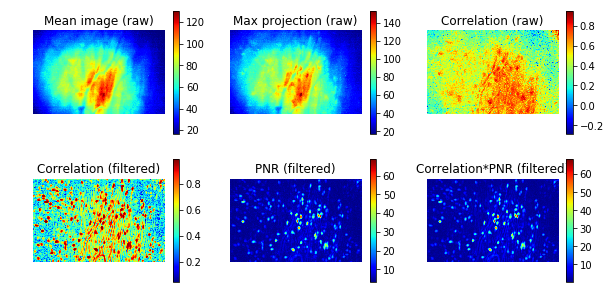

In [12]:
view_cnmf_results_widget = widgets.Button(
    description='View/Refine CNMF Results',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='View CNMF Results',
    layout=widgets.Layout(width="30%")
)
def view_results_(_):
    gSig = context.cnmf_params['gSig'][0]
    Yr, dims, T = context.YrDT
    Yr_reshaped = np.rollaxis(np.reshape(Yr, dims + (T,), order='F'),2)
    #correlation plots
    correlation_img = corr_img(Yr_reshaped, gSig, center_psf=True)
    #interactive ROI refinement
    A, C, b, f, YrA, sn, idx_components = context.cnmf_results
    kept_traces_fluo=view_edit_results(Yr_reshaped.reshape(np.prod(dims), T), A[:,context.idx_components_keep],
                                    C[context.idx_components_keep],b,f,dims[0],
                                    dims[1], thr = 0.8, image_neurons=correlation_img[1], 
                                       YrA=YrA.T[context.idx_components_keep, :])
    
view_cnmf_results_widget.on_click(view_results_)
view_results_col = widgets.VBox()
view_results_col.children = [view_cnmf_results_widget]
display(view_results_col)

In [ ]:
'''pl.figure()
idx_components = np.arange(A.shape[-1])
cm.utils.visualization.plot_contours(A[:, idx_components], correlation_img[1], thr=.9)
#%%
plt.imshow(A.sum(-1).reshape(dims, order='F'), vmax=200)'''

In [ ]:
#import importlib

In [ ]:
#plot_contours(context.YrDT, context.cnmf_results, correlation_img[1])

In [ ]:
'''from caiman_easy import *
importlib.reload(caiman_easy)'''

In [ ]:
#Yr_reshaped.reshape(np.prod(dims), T).shape

In [ ]:
'''A, C, b, f, YrA, sn, idx_components = context.cnmf_results
kept_traces_fluo=view_edit_results(Yr_reshaped.reshape(np.prod(dims), T), A.tocsc()[:,context.idx_components_keep],
                                    C[context.idx_components_keep],b,f,dims[0],
                                    dims[1], thr = 0.8, image_neurons=correlation_img[1], YrA=YrA[context.idx_components_keep, :],
                                    denoised_color='red')
#def nb_view_patches(Yr, A, C, b, f, d1, d2, YrA = None, image_neurons=None, thr=0.99, denoised_color=None,cmap='jet'):'''

In [ ]:
#pl.plot(C[context.idx_components_keep][1])

In [ ]:
#pl.imshow(np.rollaxis(Yr_reshaped, 2).max(0))

In [15]:
context.working_mc_files = ['/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/mc_rig_d1_240_d2_376_d3_1_order_C_frames_2000_.mmap']

In [ ]:
#cm.movie(A.tocsc()[:, idx_components].dot(C[idx_components, :])).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
#/Users/brandonbrown/Desktop/KhakhLab/MiniscopeProject/Xinzhu_Data/mc_rig_d1_240_d2_376_d3_1_order_C_frames_2000_.mmap

In [ ]:
##codec=cv2.cv.FOURCC('I','Y','U','V')